## Chapter 4. Using Data with PyTorch

The torch.utils.data.Dataset is an abstract class that represents a dataset. To create a custom dataset, you just need to subclass it and implement these methods:
```
__len__(self) 
```
This should return the total number of items in your dataset:
```
__getitem__(self, index) 
```
This should return a single item from your dataset at the specified index. This item will be transformed before sending it to the model

In [ ]:
# from torch.utils.data import Dataset
# class CustomDataset(Dataset):
#     def __init__(self,data,transforms=None):
#         self.data = data
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.data)
#     def __getitem__(self, indx):
#         sample = self.data[indx]
#         if transforms:
#             sample = self.transforms(sample)
#         return sample

In [2]:
# generate a synthetic dataset
import torch
torch.manual_seed(42) # for reproducibility
X = torch.arange(0,100,dtype=torch.float32)
y = 2*X-1

In [4]:
from torch.utils.data import Dataset,DataLoader
class CustomDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, indx):
        return self.x[indx] ,self.y[indx]

Then, to use the dataset, we simply create an instance of the class, initialize it with our x and y values, pass it to a DataLoader, and enumerate that:

In [7]:
# create an instance of Custom dataset
dataset = CustomDataset(X,y)
# use dataloader to handle batching and shuffling
dataloader = DataLoader(dataset,batch_size=8,shuffle=True)
# iterate over the Dataloader

for batch_idx,(inputs,labels) in enumerate(dataloader):
    print(f"Batch{batch_idx+1}")
    print("Inputs:",inputs)
    print("Labels:",labels)
    # break after the first batch for demonstration
    if batch_idx==2:
        break

Batch1
Inputs: tensor([94., 96., 61.,  4., 79., 60., 27., 73.])
Labels: tensor([187., 191., 121.,   7., 157., 119.,  53., 145.])
Batch2
Inputs: tensor([37., 26., 24., 43., 69., 88., 45., 18.])
Labels: tensor([ 73.,  51.,  47.,  85., 137., 175.,  89.,  35.])
Batch3
Inputs: tensor([95.,  6., 83.,  9., 30., 66., 28.,  8.])
Labels: tensor([189.,  11., 165.,  17.,  59., 131.,  55.,  15.])


## The ETL Process for Managing Data in Machine Learning

The Extract, Transfer, Load process consists of the three phases that are in the process’s name:

* Extract phase :
This occurs when the raw data is loaded from wherever it is stored and prepared in a way that can be transformed.

* Transform phase :
This occurs when the data is manipulated in a way that makes it suitable or improved for training. For example, batching, image augmentation, mapping to feature columns, and other such logic applied to the data can be considered part of this phase.

* Load phase :
This occurs when the data is loaded into the neural network for training.

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(
        degrees=0,  # No rotation
        translate=(0.2, 0.2),  # Translate up to 20% x and y
        scale=(0.8, 1.2),  # Zoom in or out by 20%
        shear=20,  # Shear by up to 20 degrees
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
 
# Load the datasets
train_dataset = datasets.ImageFolder(root=training_dir, 
                                     transform=train_transform)
val_dataset = datasets.ImageFolder(root=validation_dir, 
                                   transform=train_transform)
 
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

#### When Does the Actual Loading Happen?

Even though we set up the data loaders here, they don’t actually pull the data into memory until the training loop starts. So the images are loaded just in time, right before the model sees them.

**Why Is This Important?**

* This method works well even if your data is huge (too big to fit in memory).

* It keeps things consistent, so you don’t have to change much code when your data or model setup changes.

* The same tools work whether you're training on a small laptop or a big machine in the cloud.

* How you load data matters! A well-optimized data loading process can sp*eed up training a lot.

#### Optimizing the Load Phase

**CPUs** (the regular processors in computers) are good at doing tasks like downloading files, unzipping them, and going through the data step by step. So, it makes sense to use the CPU for Extract and Transform.

**GPUs and TPUs** (special processors) are really good at doing a lot of calculations very fast — which is exactly what training a model needs. So it's best to use the GPU or TPU for the Load phase, where the model is actually being trained.

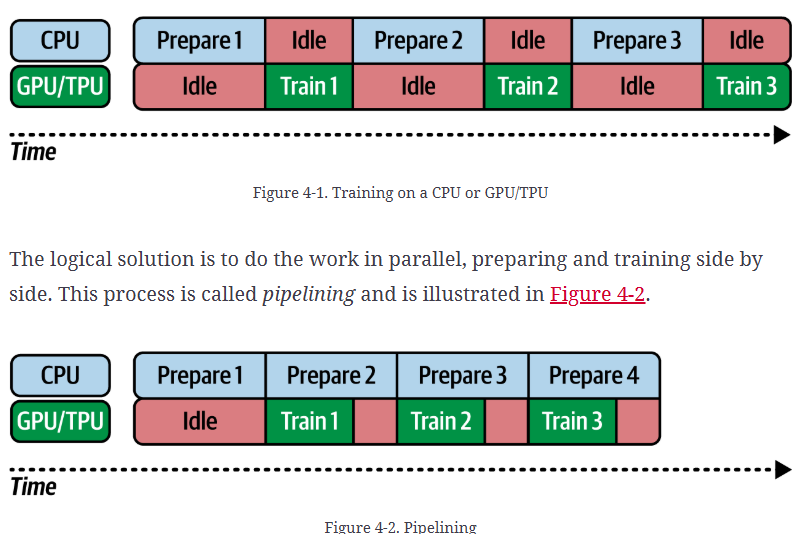

**You have a big dataset, and your machine has both a CPU and a GPU/TPU.**

You need to:

Prepare the data (Extract and Transform) — this is done by the CPU

Train the model using the data — this is done by the GPU or TPU

### The Problem Without Optimization
If you do these steps one after the other, like this:

CPU prepares Batch 1 → GPU trains on Batch 1

CPU prepares Batch 2 → GPU trains on Batch 2 and so on...

You’ll run into wasted time, because:

While the CPU is working, the GPU is doing nothing.

While the GPU is training, the CPU is doing nothing.
### The Solution: Pipelining
Instead of waiting, you can do the steps in parallel, like this:

While the GPU is training on Batch 1, the CPU starts preparing Batch 2.Then, as soon as the GPU is done with Batch 1, Batch 2 is ready to go

And this continues: both parts of the system are always working.This way, both CPU and GPU/TPU stay busy, so your system runs faster and more efficiently.

**But timing is important:** if one is faster than the other, there might still be some waiting. So you can adjust things like batch size to reduce GPU/TPU idle time (which is more expensive and powerful).

In DataLoader, you can set the number of worker processes 
```DataLoader(dataset, batch_size=64, num_workers=4)```

**num_workers=4** means it will use 4 separate processes to load data in parallel

You can adjust this number depending on your system